# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

Rossby utils

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.RossbyInit import *
from utils.WindPerturb import *

In [5]:
wind_N = 100
t_splits = 26

In [6]:
KLSampler = KarhunenLoeve_Sampler(t_splits, wind_N, decay=1.15, scaling=0.9)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

## Data Assimilation

In [7]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [8]:
ls = [6, 7, 8, 9, 10]
T = 125000

### Truth

In [9]:
data_args = initLevel(ls[-1])
true_wind = wind_sample(KLSampler, wind_weight=wind_weight, wind_speed=0.0)
truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
truth.step(T)

125000.0

In [10]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [11]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 800, 600
Hfield[Hy,Hx] = 1.0

R = [0.0001, 0.01, 0.01]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

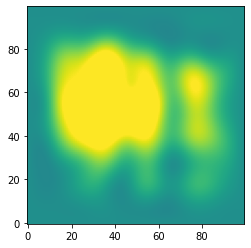

In [12]:
plt.imshow(true_wind.wind_u[25], vmin=-5,vmax=5)

Text(0.5, 0.85, 'Truth')

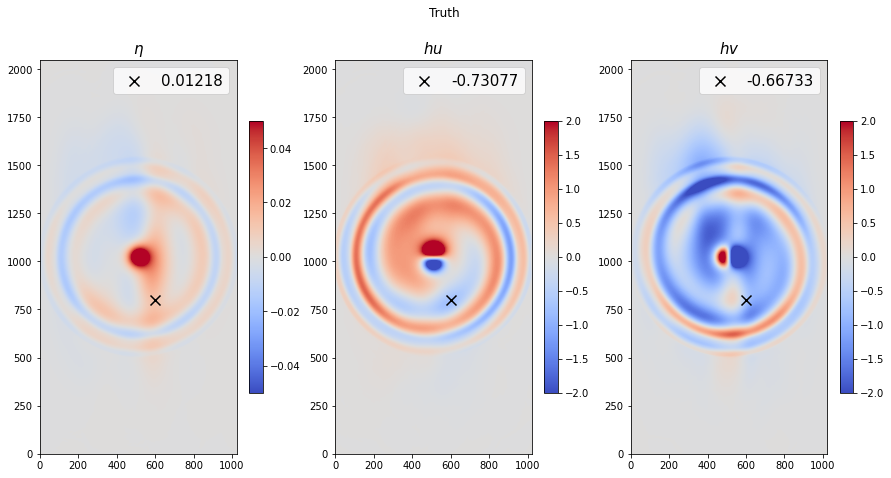

In [13]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Ensemble sizes 

In [14]:
vars_file = "../scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/vars.npy"
diff_vars_file = "../scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/diff_vars.npy"

In [15]:
from utils.RossbyAnalysis import *

In [16]:
rossbyAnalysis = RossbyAnalysis(ls, vars_file, diff_vars_file)

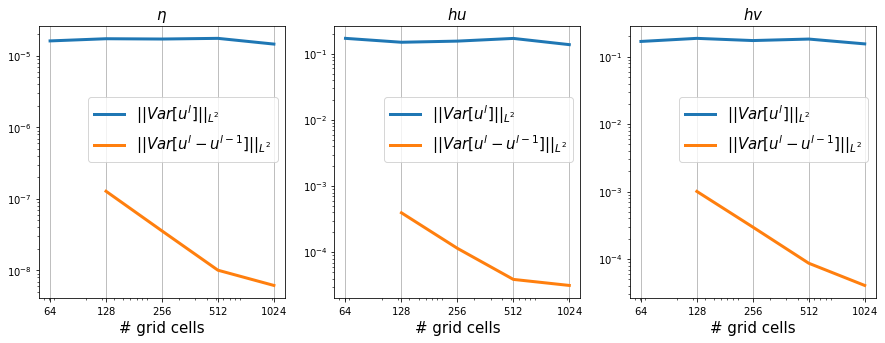

In [17]:
rossbyAnalysis.plotLvlVar()

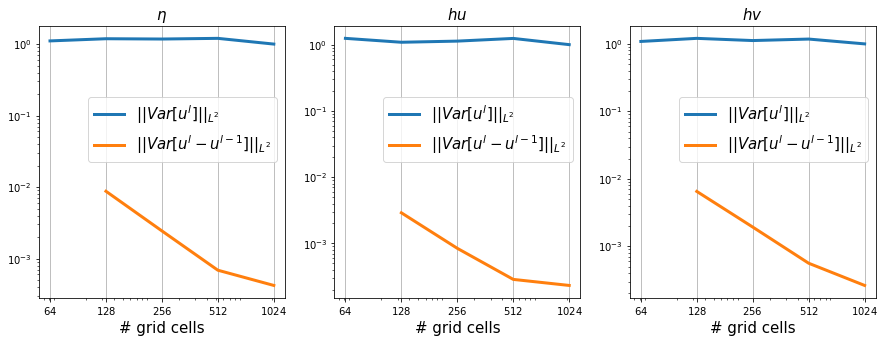

In [18]:
rossbyAnalysis.plotLvlVar(relative=True)

In [19]:
Nes = rossbyAnalysis.optimal_Ne(tau=3.0*1e-7)
Nes

array([2308,   84,   23,    7,    3], dtype=int32)

In [20]:
SL_Ne = int(round(rossbyAnalysis.work(Nes)/rossbyAnalysis._level_work(ls[-1])))
SL_Ne

6

### One-level Ensemble

In [21]:
from utils.RossbySL import *

In [22]:
SL_ensemble = initSLensemble(gpu_ctx, ls, SL_Ne, KLSampler, wind_weight, T+15000, 0.0)
SLstep(SL_ensemble, T)
SL_state = SLdownload(SL_ensemble)

SL_prior = copy.deepcopy(SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

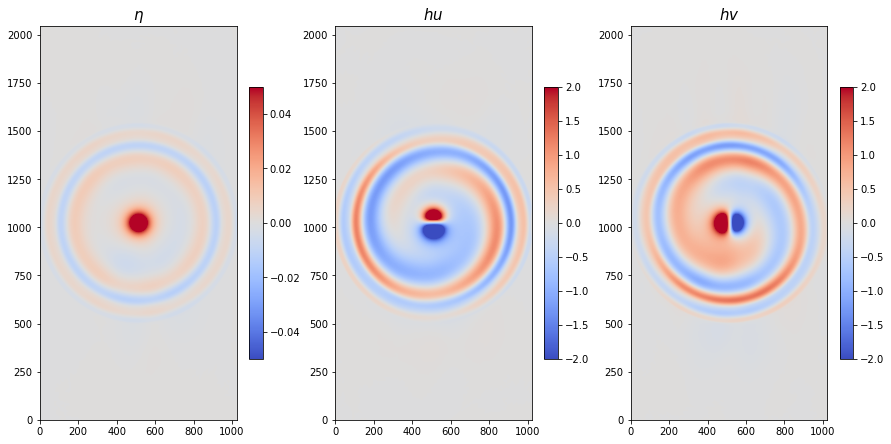

In [23]:
imshow3(np.average(SL_state, axis=-1))

In [24]:
def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.00005, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=0.25, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    # fig.suptitle("ML variance", y=0.9)

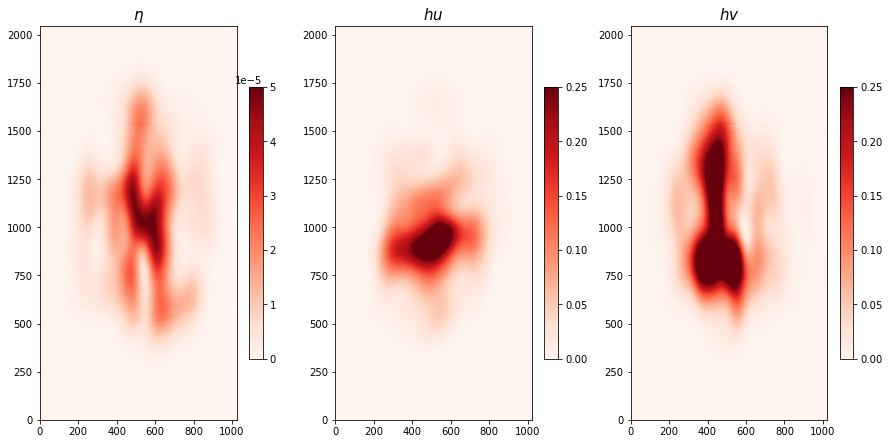

In [25]:
imshow3var(np.var(SL_state, axis=-1))

In [26]:
SL_state = SLEnKF(SL_ensemble, obs, Hx, Hy, R)
SLupload(SL_ensemble, SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

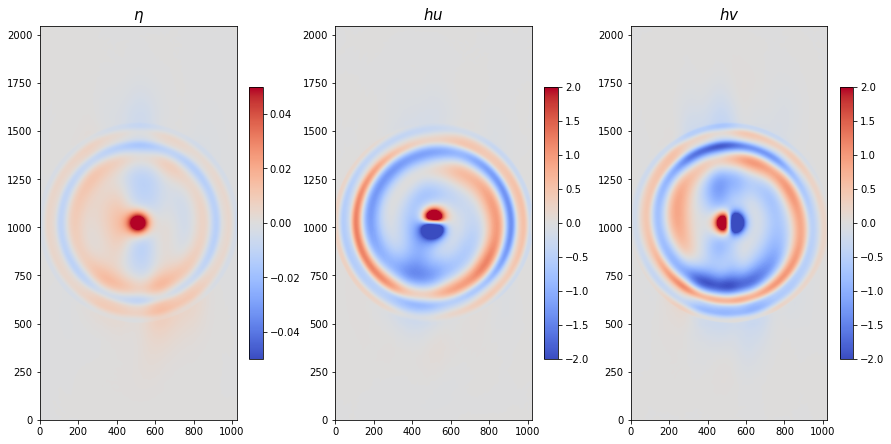

In [27]:
imshow3(np.average(SL_state, axis=-1))

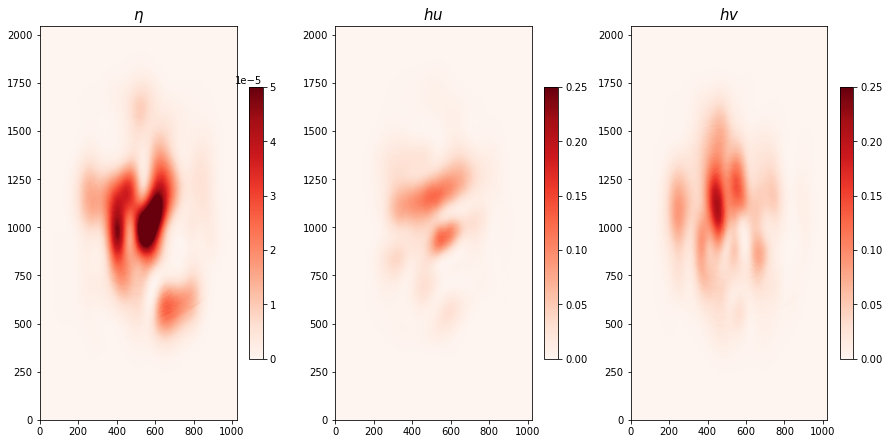

In [28]:
imshow3var(np.var(SL_state, axis=-1))

### Multi-level Ensemble

In [29]:
from utils.RossbyEnsembleInit import * 

In [30]:
Nes = [100, 75, 50, 25, 10]

In [31]:
ML_ensemble = initMLensemble(gpu_ctx, ls, Nes, KLSampler, wind_weight, T+15000, wind_speed=0.0)

In [32]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [33]:
from importlib import reload
reload(MultiLevelOceanEnsemble)

<module 'gpuocean.ensembles.MultiLevelOceanEnsemble' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/ensembles/MultiLevelOceanEnsemble.py'>

In [34]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [35]:
MLOceanEnsemble.step(T)

In [36]:
ML_prior_state = copy.deepcopy(MLOceanEnsemble.download())

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

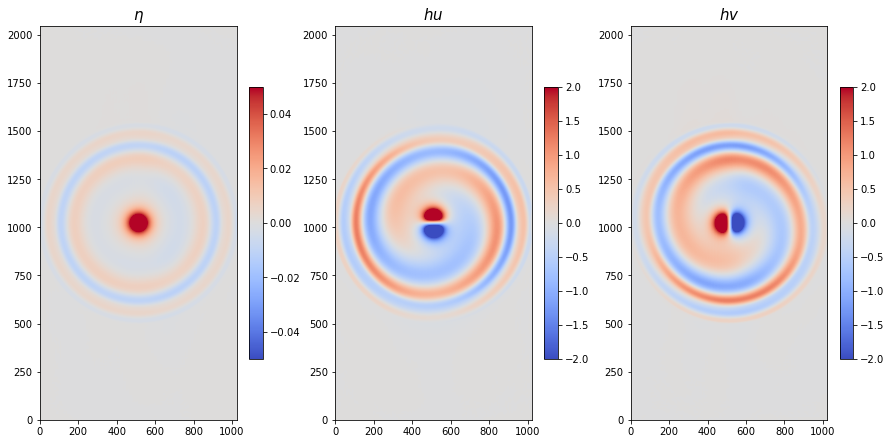

In [37]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean)

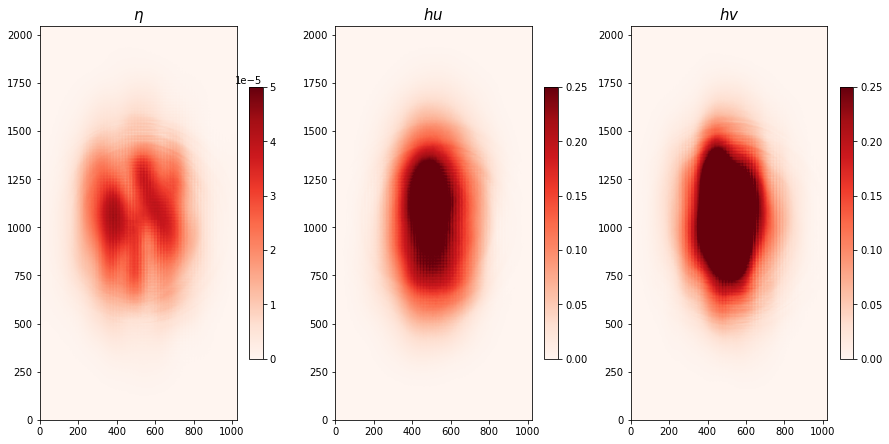

In [38]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar)

In [39]:
from gpuocean.dataassimilation import MLEnKFOcean
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [40]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 5*1e7, relax_factor = 1.0)

Text(0.5, 0.9, 'Kalman Gain')

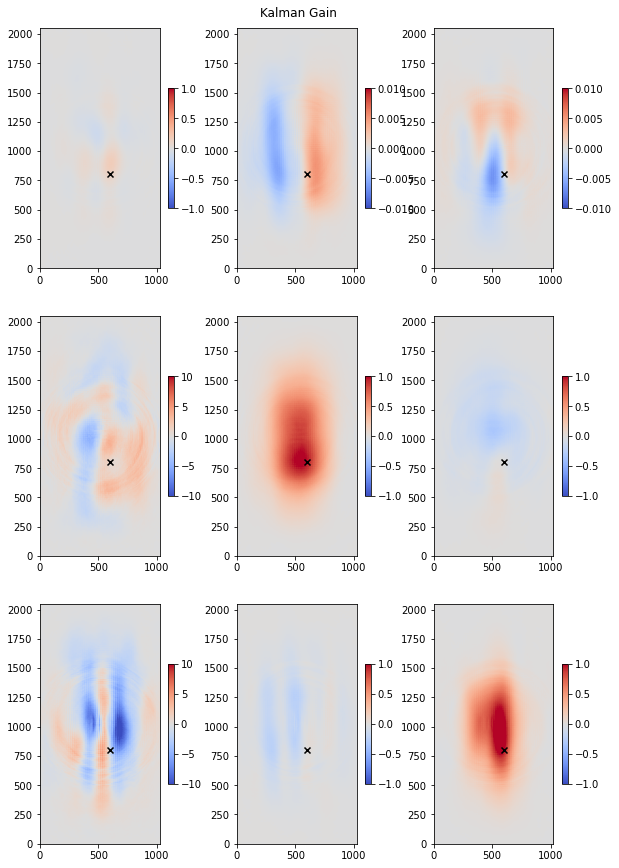

In [41]:
ML_K_field = ML_K.reshape(MLOceanEnsemble.download()[-1][0].shape[:-1] + (3,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

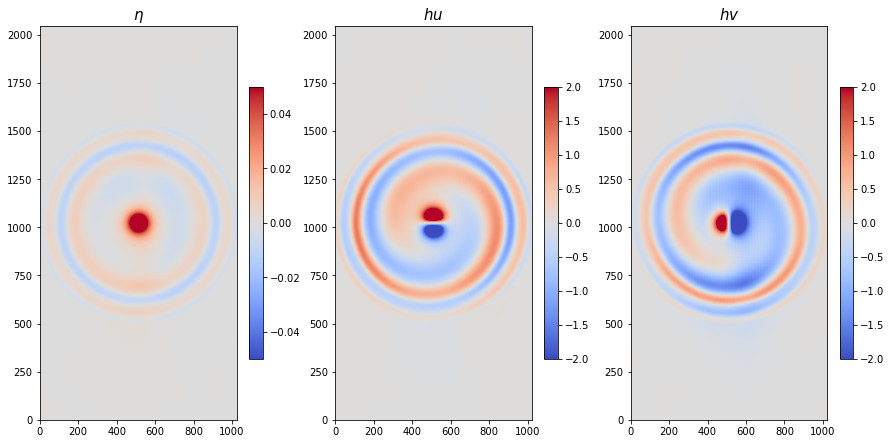

In [42]:
imshow3(MLOceanEnsemble.estimate(np.mean))

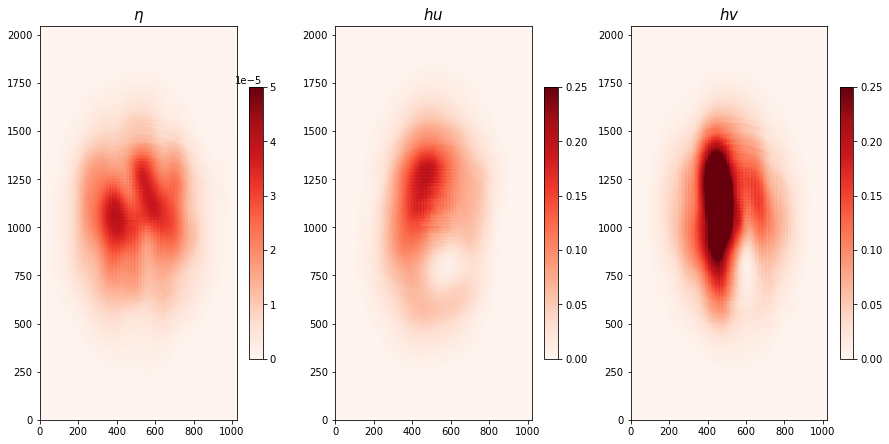

In [43]:
imshow3var(MLOceanEnsemble.estimate(np.var))